# Notebook to benchmark RAPIDS+Pytorch vs Huggingface tokenizer with Triton

This notebook calls a ensemble model which uses RAPIDS+Pytorch with Triton


<img src="notebook_images/ensemble_rapids_simple.jpg" width="300" height="400">

### Client Setup

In [ ]:
# !pip install nvidia-pyindex
# !pip install tritonclient[all]

### Import Libraries

In [1]:
import numpy as np
import json

import grpc
from tritonclient.grpc import service_pb2
from tritonclient.grpc import service_pb2_grpc
import tritonclient.grpc as grpcclient
from functools import partial

###  Connect to the Triton End to End Model 

In [2]:
url='localhost:8001'

triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)

channel = grpc.insecure_channel(url)
grpc_stub = service_pb2_grpc.GRPCInferenceServiceStub(channel)

In [3]:
#preprocessing_model = 'end_to_end_onnx'
#preprocessing_model = 'rapids_tokenizer'
preprocessing_model = 'end_to_end_pytorch_rapids'
request = service_pb2.ModelMetadataRequest(name=preprocessing_model,
                                           version='1')
response = grpc_stub.ModelMetadata(request)
print("model metadata:\n{}".format(response))

model metadata:
name: "end_to_end_pytorch_rapids"
versions: "1"
platform: "ensemble"
inputs {
  name: "product_reviews"
  datatype: "BYTES"
  shape: -1
  shape: -1
}
outputs {
  name: "preds"
  datatype: "INT32"
  shape: -1
  shape: -1
}



### Define functions for tokenization and end-to-end inference

In [4]:
def send_preprocess_request(log_ar, model_name='rapids_tokenizer'):
    triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)
    input_grpc = grpcclient.InferInput("product_reviews",log_ar.shape,"BYTES")
    input_grpc.set_data_from_numpy(log_ar)

    outputs = []
    outputs.append(grpcclient.InferRequestedOutput('input_ids'))
    outputs.append(grpcclient.InferRequestedOutput('attention_mask'))

    
    output = triton_client.infer(model_name=model_name,
                               inputs=[input_grpc],
                              outputs=outputs)
    


    return output

In [5]:
def send_inference_request(log_ar, model_name='end_to_end_pytorch_rapids'):
    triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)
    input_grpc = grpcclient.InferInput("product_reviews",log_ar.shape,"BYTES")
    input_grpc.set_data_from_numpy(log_ar)
    outputs = []
    outputs.append(grpcclient.InferRequestedOutput('preds'))
    
    output = triton_client.infer(model_name=model_name,
                               inputs=[input_grpc],
                              outputs=outputs)
    

    return output


## Test if the inference is correct with both tokenizers

##  Predictions

##### 1 is positive, 0 is negative

In [6]:
log_ls = ['The product is great', 'This product is bad','This product is good', 'This product is really bad']*1
log_ls = [l.encode('utf-8') for l in log_ls]
log_ar = np.array(log_ls).reshape(1,len(log_ls))
print(log_ar.shape, log_ar.squeeze().shape, type(log_ar))

(1, 4) (4,) <class 'numpy.ndarray'>


In [7]:
# RAPIDS
#output = send_inference_request(np.concatenate((log_ar,log_ar), axis=0).squeeze(),'end_to_end_pytorch_rapids')
output = send_inference_request(log_ar,'end_to_end_pytorch_rapids')
output.as_numpy('preds')

array([[1, 0, 1, 0]], dtype=int32)

In [8]:
# Huggingface
output = send_inference_request(log_ar,'end_to_end_pytorch_huggingface')
output.as_numpy('preds')

array([[1, 0, 1, 0]], dtype=int32)

## Benchmark RAPIDS vs Huggingface tokenizers

##### Utility functions from https://github.com/ELS-RD/transformer-deploy.git

In [9]:
import time
from contextlib import contextmanager
from typing import Dict, List, Tuple, Union
def print_timings(name: str, timings: List[float]) -> None:
    """
    Format and print inference latencies.
    :param name: inference engine name
    :param timings: latencies measured during the inference
    """
    mean_time = 1e3 * np.mean(timings)
    std_time = 1e3 * np.std(timings)
    min_time = 1e3 * np.min(timings)
    max_time = 1e3 * np.max(timings)
    median, percent_95_time, percent_99_time = 1e3 * np.percentile(timings, [50, 95, 99])
    print(
        f"[{name}] "
        f"mean={mean_time:.4f}ms, "
        f"sd={std_time:.2f}ms, "
        f"min={min_time:.2f}ms, "
        f"max={max_time:.2f}ms, "
        f"median={median:.2f}ms, "
        f"95p={percent_95_time:.2f}ms, "
        f"99p={percent_99_time:.2f}ms"
    )

@contextmanager
def track_infer_time(buffer: List[int]) -> None:
    """
    A context manager to perform latency measures
    :param buffer: a List where to save latencies for each input
    """
    start = time.perf_counter()
    yield
    end = time.perf_counter()
    buffer.append(end - start)

### Prepare Input 
##### Generate input of variable number of sequences and seq length

In [10]:
def prepare_input(sentence='This product is great', lenfac=100, num_seq=100):

    log_txt = sentence * lenfac
    log_ls = [log_txt] * num_seq
    log_ls = [l.encode('utf-8') for l in log_ls]
    
    return np.array(log_ls).reshape(1,len(log_ls))

### Prepare Input 

## Run the benchmark: with procedurally generated data


## Fixed Seq length, variable batch size

In [11]:
# dictionary for the benchmark results
results = {}

# Sequence length
lenfac = 64 # seq_length is 256

# Benchmark parameters
num_warmup_runs = 10
num_bench_runs = 10

# Number of sequences to proces: batch size
#num_seqs= [2, 10, 100, 1000]
num_seqs = [2**x for x in range(1,11)]

# Run a preprocess (tokenization) or an end-to-end inference request
modes = ["preprocess", "inference"] # do not put this in the loop to avoid if conditions

# Backends to try: cudf (RAPIDS) vs hugf (Hugging Face)
backends = ["rapids", "huggingface"]


# Number of experiments
num_exp = len(num_seqs)
# Number of modes
num_modes = len(modes)
# Number of backends
num_backends = len(backends)


for num_seq in num_seqs:
    # Input for the current benchmark
    #log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    
    for backend in backends:
        
        # Preprocessing
        mode = modes[0]
        tag = "{}_{}_{}".format(mode, backend, num_seq)  
        model_name = "{}_tokenizer".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)

        # Benchmark
        time_buffer = []        
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):                
                output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)
        results[tag] = time_buffer

        # Inference
        mode = modes[1]
        tag = "{}_{}_{}".format(mode, backend, num_seq)            
        model_name = "end_to_end_pytorch_{}".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_inference_request(log_ar, model_name=model_name)
        
        # Benchmark
        time_buffer = []
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):
                output = send_inference_request(log_ar, model_name=model_name)
        results[tag] = time_buffer        

In [12]:
for name, time_buffer in results.items():
    print_timings(name=name, timings=time_buffer)

[preprocess_rapids_2] mean=3.9779ms, sd=0.34ms, min=3.66ms, max=4.79ms, median=3.90ms, 95p=4.61ms, 99p=4.76ms
[inference_rapids_2] mean=23.4622ms, sd=1.79ms, min=21.09ms, max=25.84ms, median=23.68ms, 95p=25.62ms, 99p=25.80ms
[preprocess_huggingface_2] mean=3.6979ms, sd=0.15ms, min=3.55ms, max=4.07ms, median=3.64ms, 95p=3.96ms, 99p=4.05ms
[inference_huggingface_2] mean=23.3853ms, sd=1.51ms, min=20.64ms, max=24.49ms, median=24.31ms, 95p=24.47ms, 99p=24.48ms
[preprocess_rapids_10] mean=5.4069ms, sd=0.32ms, min=4.87ms, max=5.87ms, median=5.42ms, 95p=5.84ms, 99p=5.86ms
[inference_rapids_10] mean=47.2213ms, sd=0.27ms, min=46.75ms, max=47.57ms, median=47.31ms, 95p=47.54ms, 99p=47.57ms
[preprocess_huggingface_10] mean=6.6191ms, sd=1.10ms, min=5.83ms, max=9.68ms, median=6.23ms, 95p=8.61ms, 99p=9.47ms
[inference_huggingface_10] mean=47.7351ms, sd=0.23ms, min=47.19ms, max=48.05ms, median=47.80ms, 95p=47.99ms, 99p=48.04ms
[preprocess_rapids_100] mean=8.1388ms, sd=0.44ms, min=7.50ms, max=8.98ms, me

In [13]:
# prepare the plot data
times = 1e3 * np.mean(np.array(list(results.values())), axis=1).reshape((num_modes * num_exp, num_backends))
rapids_pre_times = times[::2, 0].reshape((-1,1))
rapids_inf_times = times[::2, 1].reshape((-1,1))
huggingface_pre_times = times[1::2, 0].reshape((-1,1))
huggingface_inf_times = times[1::2, 1].reshape((-1,1))    

In [47]:
import matplotlib.pyplot as plt

def plot_results(data, num_seqs, val_range, title='cuDF vs Huggingface', columns = ('Hugging Face', 'RAPIDS'), legend=['Hugging Face', 'cuDF'], row_label="batch_size", figsize=(8,6), dpi=150):
    from matplotlib.pyplot import figure
    
    figure(figsize=figsize, dpi=dpi)

    dataf = np.flip(data, axis=0)
    
    columns = columns
    rows =  [row_label + ': %d' % num_seq for num_seq in num_seqs]

    
    values = val_range 
    #values = np.arange(0, np.amax(data), np.amax(data)/10)
    value_increment = 1

    # Get some pastel shades for the colors
    colors = plt.cm.RdBu(np.linspace(0.15, 0.95, len(rows)))
    n_rows = len(data)
  
    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4


    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))
    linecolors=["r", "b", "g", "k"]
    for i in range(data.shape[1]):
        datamarker = linecolors[i]+'-'
        print('shape: ', data.shape[1])
        plt.plot(np.arange(0, n_rows), data[:, i], datamarker, alpha=0.25)
        #plt.plot(np.arange(0, n_rows), data[:, 1], 'b-', alpha=0.25)

    plt.grid(alpha=0.5)
    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        for i in range(data.shape[1]):
            datamarker = linecolors[i]+'.'
            #plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
            plt.plot(row, data[row, i], datamarker, markersize=12)
            #plt.plot(row, data[row, 1], 'b.', markersize=12)
        
        #cell_text.append(['%.2f' % (x) for x in y_offset])
        cell_text.append(['%.2f' % (x) for x in dataf[row]])
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom',
                          cellLoc='center')

    the_table.set_fontsize(7)

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel("Time (ms)", fontsize=10)
    plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xticks([])
    plt.title(title, fontsize=8, fontweight='bold')
    

    from matplotlib.font_manager import FontProperties
    # Make table labels bold
    for (row, col), cell in the_table.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    plt.legend(legend, fontsize=6.5)
    plt.show()

### Plot results

shape:  2
shape:  2


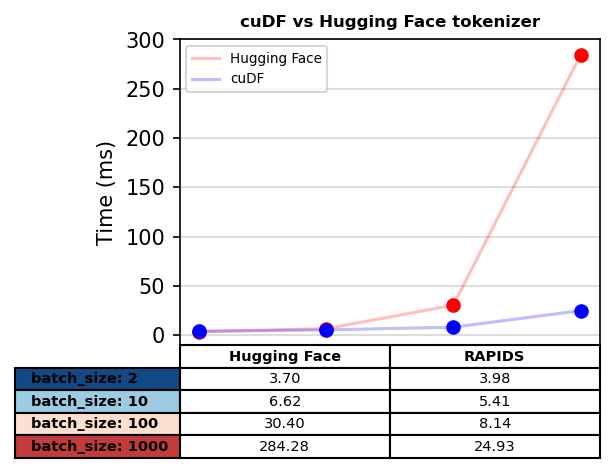

In [48]:

# cuDF vs Hugging Face: tokenization 
value_range = np.arange(0, 350, 50)
plotdata_pre = np.concatenate((huggingface_pre_times, rapids_pre_times), axis=1)
title = 'cuDF vs Hugging Face tokenizer'
columns = ('Hugging Face', 'RAPIDS')
legend=['Hugging Face', 'cuDF']
plot_results(plotdata_pre, num_seqs, value_range, title, columns, legend, figsize=(4,3))

shape:  2
shape:  2


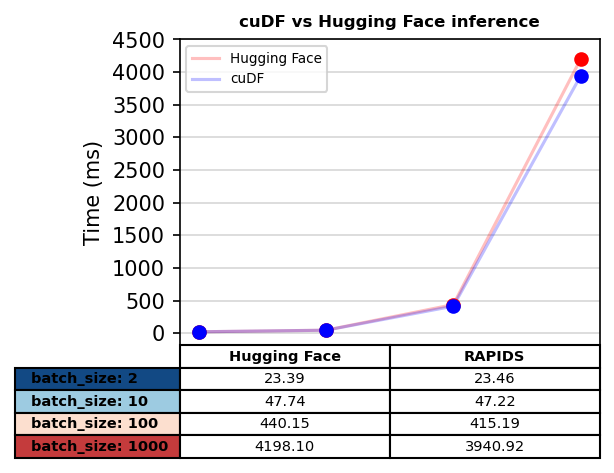

In [49]:
# cuDF vs Hugging Face: inference
value_range = np.arange(0, 5000, 500)
plotdata_inf = np.concatenate((huggingface_inf_times, rapids_inf_times), axis=1)
title = 'cuDF vs Hugging Face inference'
columns = ('Hugging Face', 'RAPIDS')
plot_results(plotdata_inf, num_seqs, value_range, title, columns, legend, figsize=(4,3))

shape:  2
shape:  2


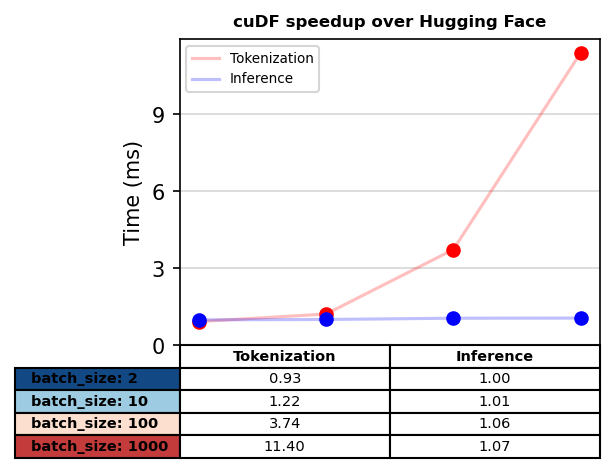

In [50]:
# cuDF vs Hugging Face: speedup
value_range = np.arange(0, 12, 3)
speedups = np.concatenate(((huggingface_pre_times/rapids_pre_times).reshape(-1,1), (huggingface_inf_times/rapids_inf_times).reshape(-1,1)), axis=1)
columns = ('Tokenization', 'Inference')
title = 'cuDF speedup over Hugging Face'
legend=['Tokenization', 'Inference']
plot_results(speedups, num_seqs, value_range, title, columns, legend, figsize=(4,3))

## Fixed Batch size, variable sequence length

In [25]:
# dictionary for the benchmark results
results_pre = {}

# Sequence length
#lenfacs =  [2, 10, 100, 1000]
lenfacs = [2**x for x in range(1,11)]

# Benchmark parameters
num_warmup_runs = 10
num_bench_runs = 10

# Number of sequences to proces: batch size
num_seq = 128

# Run a preprocess (tokenization) or an end-to-end inference request
modes = ["preprocess", "inference"] # do not put this in the loop to avoid if conditions

# Backends to try: cudf (RAPIDS) vs hugf (Hugging Face)
backends = ["rapids", "huggingface"]

# Number of experiments
num_exp = len(num_seqs)
# Number of modes
num_modes = len(modes)
# Number of backends
num_backends = len(backends)

for lenfac in lenfacs:
    # Input for the current benchmark
    #log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    log_ar = prepare_input("Good", lenfac=lenfac, num_seq=num_seq)
    
    for backend in backends:
        
        # Preprocessing
        mode = modes[0]
        tag = "{}_{}_{}".format(mode, backend, lenfac)  
        model_name = "{}_tokenizer".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)

        # Benchmark
        time_buffer = []        
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):                
                output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)
        results[tag] = time_buffer

shape:  2
shape:  2


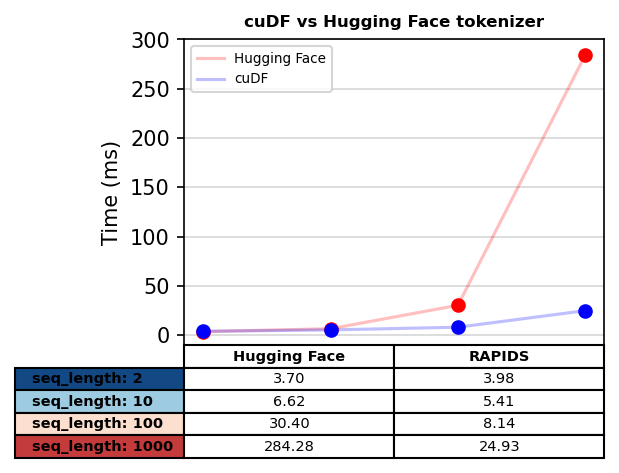

In [51]:

value_range = np.arange(0, 350, 50)
plotdata_pre = np.concatenate((huggingface_pre_times, rapids_pre_times), axis=1)
title = 'cuDF vs Hugging Face tokenizer'
columns = ('Hugging Face', 'RAPIDS')
legend=['Hugging Face', 'cuDF']
rowlabel = "seq_length"
plot_results(plotdata_pre, num_seqs, value_range, title, columns, legend, rowlabel, figsize=(4,3))

shape:  1


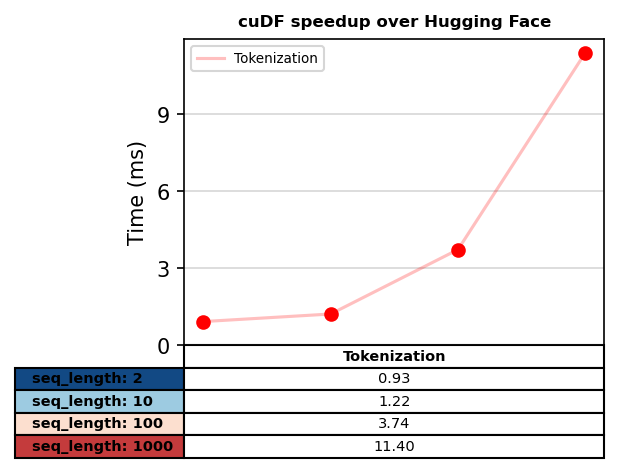

In [54]:
value_range = np.arange(0, 12, 3)
speedups = (huggingface_pre_times/rapids_pre_times).reshape(-1,1)
columns = ('Tokenization','')
title = 'cuDF speedup over Hugging Face'
legend=['Tokenization']
rowlabel = "seq_length"
plot_results(speedups, num_seqs, value_range, title, columns, legend, rowlabel, figsize=(4,3))